# Machine Learning Spring 2025

> **Project 1 - Temperature Prediction**<br><br>Team: ST_ML2025_2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import re
import math

In [2]:
plt.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
# Load the given datasets(located in the input folder)
train_df = pd.read_csv("./input/train_dataset.csv")
test_df = pd.read_csv("./input/test_dataset.csv")
station_info_df = pd.read_csv("./input/station_info.csv")
sample_submission_df = pd.read_csv("./input/submission_sample.csv")

# Dataset 분석

주어진 데이터셋의 구성은 다음과 같다.

- `train_dataset.csv`: 동두천, 서울, 강화, 인천, 이천, 양평 관측소의 2019-2024년 데이터셋
- `test_dataset.csv`: 파주, 수원 관측소 데이터셋
- `station_info.csv`: 기상 관측소별 정보

In [4]:
train_df.sample(10)

,id,station,station_name,date,cloud_cover_0,cloud_cover_1,cloud_cover_10,cloud_cover_11,cloud_cover_12,cloud_cover_13,...,wind_speed_23,wind_speed_3,wind_speed_4,wind_speed_5,wind_speed_6,wind_speed_7,wind_speed_8,wind_speed_9,climatology_temp,target
2050,2050,98,동두천,08-16,1.0,0.0,4.0,3.0,2.0,1.0,...,0.6,0.5,0.4,0.4,0.3,0.2,0.4,0.2,26.087500,1.712500
9523,13902,202,양평,02-08,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,2.5,2.6,1.9,2.1,1.8,1.9,2.8,-0.941071,-0.158929
6340,8528,112,인천,05-16,3.0,1.0,0.0,0.0,1.0,1.0,...,2.5,3.5,3.0,2.5,2.4,3.0,1.6,1.6,18.869643,-1.869643
4555,6743,112,인천,06-27,8.0,1.0,9.0,8.0,8.0,6.0,...,2.1,1.4,1.4,0.8,0.5,1.4,0.9,1.3,24.257143,-1.757143
2264,4452,108,서울,03-19,0.0,7.0,0.0,1.0,9.0,8.0,...,1.3,0.6,0.7,0.4,1.2,1.1,1.3,1.4,6.646429,3.653571
9439,13818,202,양평,11-16,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.3,0.0,0.3,0.1,0.6,0.1,0.1,7.121429,5.878571
7636,12015,201,강화,12-04,0.0,0.0,3.0,0.0,0.0,0.0,...,1.3,1.6,0.7,1.4,0.0,0.0,0.7,0.2,0.283929,0.516071
8974,13353,202,양평,08-09,2.0,5.0,0.0,0.0,0.0,0.0,...,0.3,0.1,1.0,0.7,1.0,0.6,0.9,1.1,26.446429,3.753571
12346,16725,203,이천,11-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9,0.0,0.2,0.2,0.0,0.0,0.0,0.5,9.883929,-1.483929
10192,14571,202,양평,12-11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.6,0.2,0.5,0.5,0.6,0.4,0.3,0.5,0.567857,0.032143


In [5]:
train_df.describe()

,id,station,cloud_cover_0,cloud_cover_1,cloud_cover_10,cloud_cover_11,cloud_cover_12,cloud_cover_13,cloud_cover_14,cloud_cover_15,...,wind_speed_23,wind_speed_3,wind_speed_4,wind_speed_5,wind_speed_6,wind_speed_7,wind_speed_8,wind_speed_9,climatology_temp,target
count,13132.000000,13132.000000,12945.000000,12920.000000,12916.000000,12926.000000,12931.000000,12926.000000,12919.000000,12938.000000,...,13122.000000,13120.000000,13116.000000,13112.000000,13119.000000,13120.000000,13125.000000,13127.000000,13132.000000,13132.000000
mean,9484.110493,153.980658,2.915798,3.022291,3.126742,3.092063,3.046400,3.035046,2.992182,2.911115,...,-0.032754,-2.491814,-0.234637,-1.011882,-4.068389,-7.119787,-10.073272,-9.119029,12.658557,0.221979
std,5311.954253,48.183220,3.646779,3.652165,3.659422,3.589739,3.512063,3.483002,3.462070,3.440298,...,123.464434,195.197628,123.489868,151.258218,230.949420,289.453706,337.895538,326.432094,10.023504,2.960544
min,0.000000,98.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-4.487500,-12.864286
25%,5470.750000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.600000,0.400000,0.400000,0.400000,0.400000,0.400000,0.500000,0.700000,3.292857,-1.643052
50%,8753.500000,112.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.200000,1.000000,0.900000,0.900000,0.900000,0.900000,1.000000,1.300000,12.842857,0.157143
75%,14227.250000,202.000000,6.000000,6.000000,7.000000,7.000000,6.000000,6.000000,6.000000,6.000000,...,2.100000,1.900000,1.900000,1.800000,1.800000,1.800000,2.000000,2.200000,22.271429,2.045536
max,17510.000000,203.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.700000,11.300000,9.500000,10.600000,12.400000,11.100000,11.300000,9.400000,28.455357,11.778571


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13132 entries, 0 to 13131
Columns: 342 entries, id to target
dtypes: float64(338), int64(2), object(2)
memory usage: 34.3+ MB


## Feature 분석

### Feature 분류 및 설명

In [7]:
def search_time_based_feature_names(df):
    "각 시간별로 구성된 feature들(e.g. 'cloud_cover_0', 'cloud_cover_1' ...)에 대해 각각의 고유한 이름(e.g. 'cloud_cover')을 찾는다."

    time_based_features_pattern = re.compile(r"^(.*)_(\d{1,2})$")
    searched_time_based_feature_names = set()

    for column in df.columns:
        match = time_based_features_pattern.match(column)
        if match:
            feature_name, hour = match.groups()
            hour = int(hour)
            searched_time_based_feature_names.add(feature_name)

    return searched_time_based_feature_names

time_based_feature_names = search_time_based_feature_names(train_df)

print(len(time_based_feature_names))
print(time_based_feature_names)

14
{'precipitation', 'sunshine_duration', 'cloud_cover', 'snow_depth', 'wind_direction', 'local_pressure', 'vapor_pressure', 'dew_point', 'humidity', 'surface_temp', 'visibility', 'sea_level_pressure', 'wind_speed', 'min_cloud_height'}


In [8]:
categorical_features = [col for col in train_df.columns if train_df[col].dtype == 'object' or train_df[col].dtype.name == 'category']

In [9]:
categorical_features

['station_name', 'date']

train dataset에 있는 feature를 특성에 따라 다음과 같은 카테고리별로 정리하였다.

1. Data 식별
   - `id`: 순서(identical)
   - `station`: 지상관측소 번호(98: "동두천", 201: "강화" 등)
   - `station_name`: 지상관측소 이름("동두천", "서울", "강화" 등)
   - `date`: 날짜(월-일 형식, 1월 29일은 "01-29"로 표기)

2. 구름 관련 feature
    - `cloud_cover_[0-23]`: 증하층운량(10분위, 0~10)
    - `min_cloud_height_[0-23]`: 시간별 최저운고(100m 단위)

3. 온도 관련 feature
    - `dew_point_[0-23]`: 시간별 이슬점 온도(°C)
    - `surface_temp_[0-23]`: 시간별 지면온도(°C)
    - `climatology_temp`: 해당 날짜의 평균 기온(°C) (7년 동안 평균)

4. 습도 관련 feature
    - `humidity_[0-23]`: 시간별 습도(%)
    - `vapor_pressure_[0-23]`: 시간별 증기압(hPa)
    - `percipitation_[0-23]`: 시간별 강수량(mm)
    - `snow_depth_[0-23]`: 시간별 적설(cm)

5. 기압 관련 feature
    - `local_pressure_[0-23]`: 시간별 현지기압(hPa)
    - `sea_level_pressure_[0-23]`: 시간별 해면기압(hPa)

6. 가시성 관련 feature
    - `visibility_[0-23]`: 시간별 시정(10m 단위)
    - `sunshine_duration_[0-23]`: 시간별 일조(hr)

7. 바람 관련 feature
    - `wind_speed_[0-23]`: 시간별 풍속(m/s)
    - `wind_direction_[0-23]`: 시간별 풍향(도 단위)

8. target feature
    - `target`: 시간별 기온(°C, 다음날 평균 기온(°C)에서 `climatology_temp`를 뺀 값)


### 결측치 패턴

1. `-9999`: 관측소 기계에서 감지한 결측치 또는 이상치
2. `NaN`:
    - `sunshine_duration`: 야간 시간대(0, 1, 2, 3, 4, 5, 22, 23시), 즉 해가 없는 시간대
    - `snow_depth`: 눈이 오지 않은 경우
    - `precipitation`: 비가 오지 않은 경우




### 결측치 식별

#### Time-based feature에 대한 결측치
**시간대별 결측률 분석**

In [10]:
def analyze_time_based_features_missing_by_hour(ax, df, base_name):
    hour_missing = {}

    cols = [col for col in df.columns if col.startswith(base_name + "_")]

    for col in cols:
        try:
            hour = int(col.split("_")[-1])
            missing_ratio = df[col].isnull().mean()
            hour_missing[hour] = missing_ratio
        except ValueError:
            continue

    hours = sorted(hour_missing.keys())
    missing_values = [hour_missing[h] for h in hours]

    sns.lineplot(x=hours, y=missing_values, marker="o", ax=ax, color="steelblue")
    ax.set_title(f"{base_name}")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Missing Ratio")
    ax.set_xticks(hours)
    ax.set_ylim(0, max(missing_values) + 0.0025)
    ax.grid(True, linestyle="--", alpha=0.5)

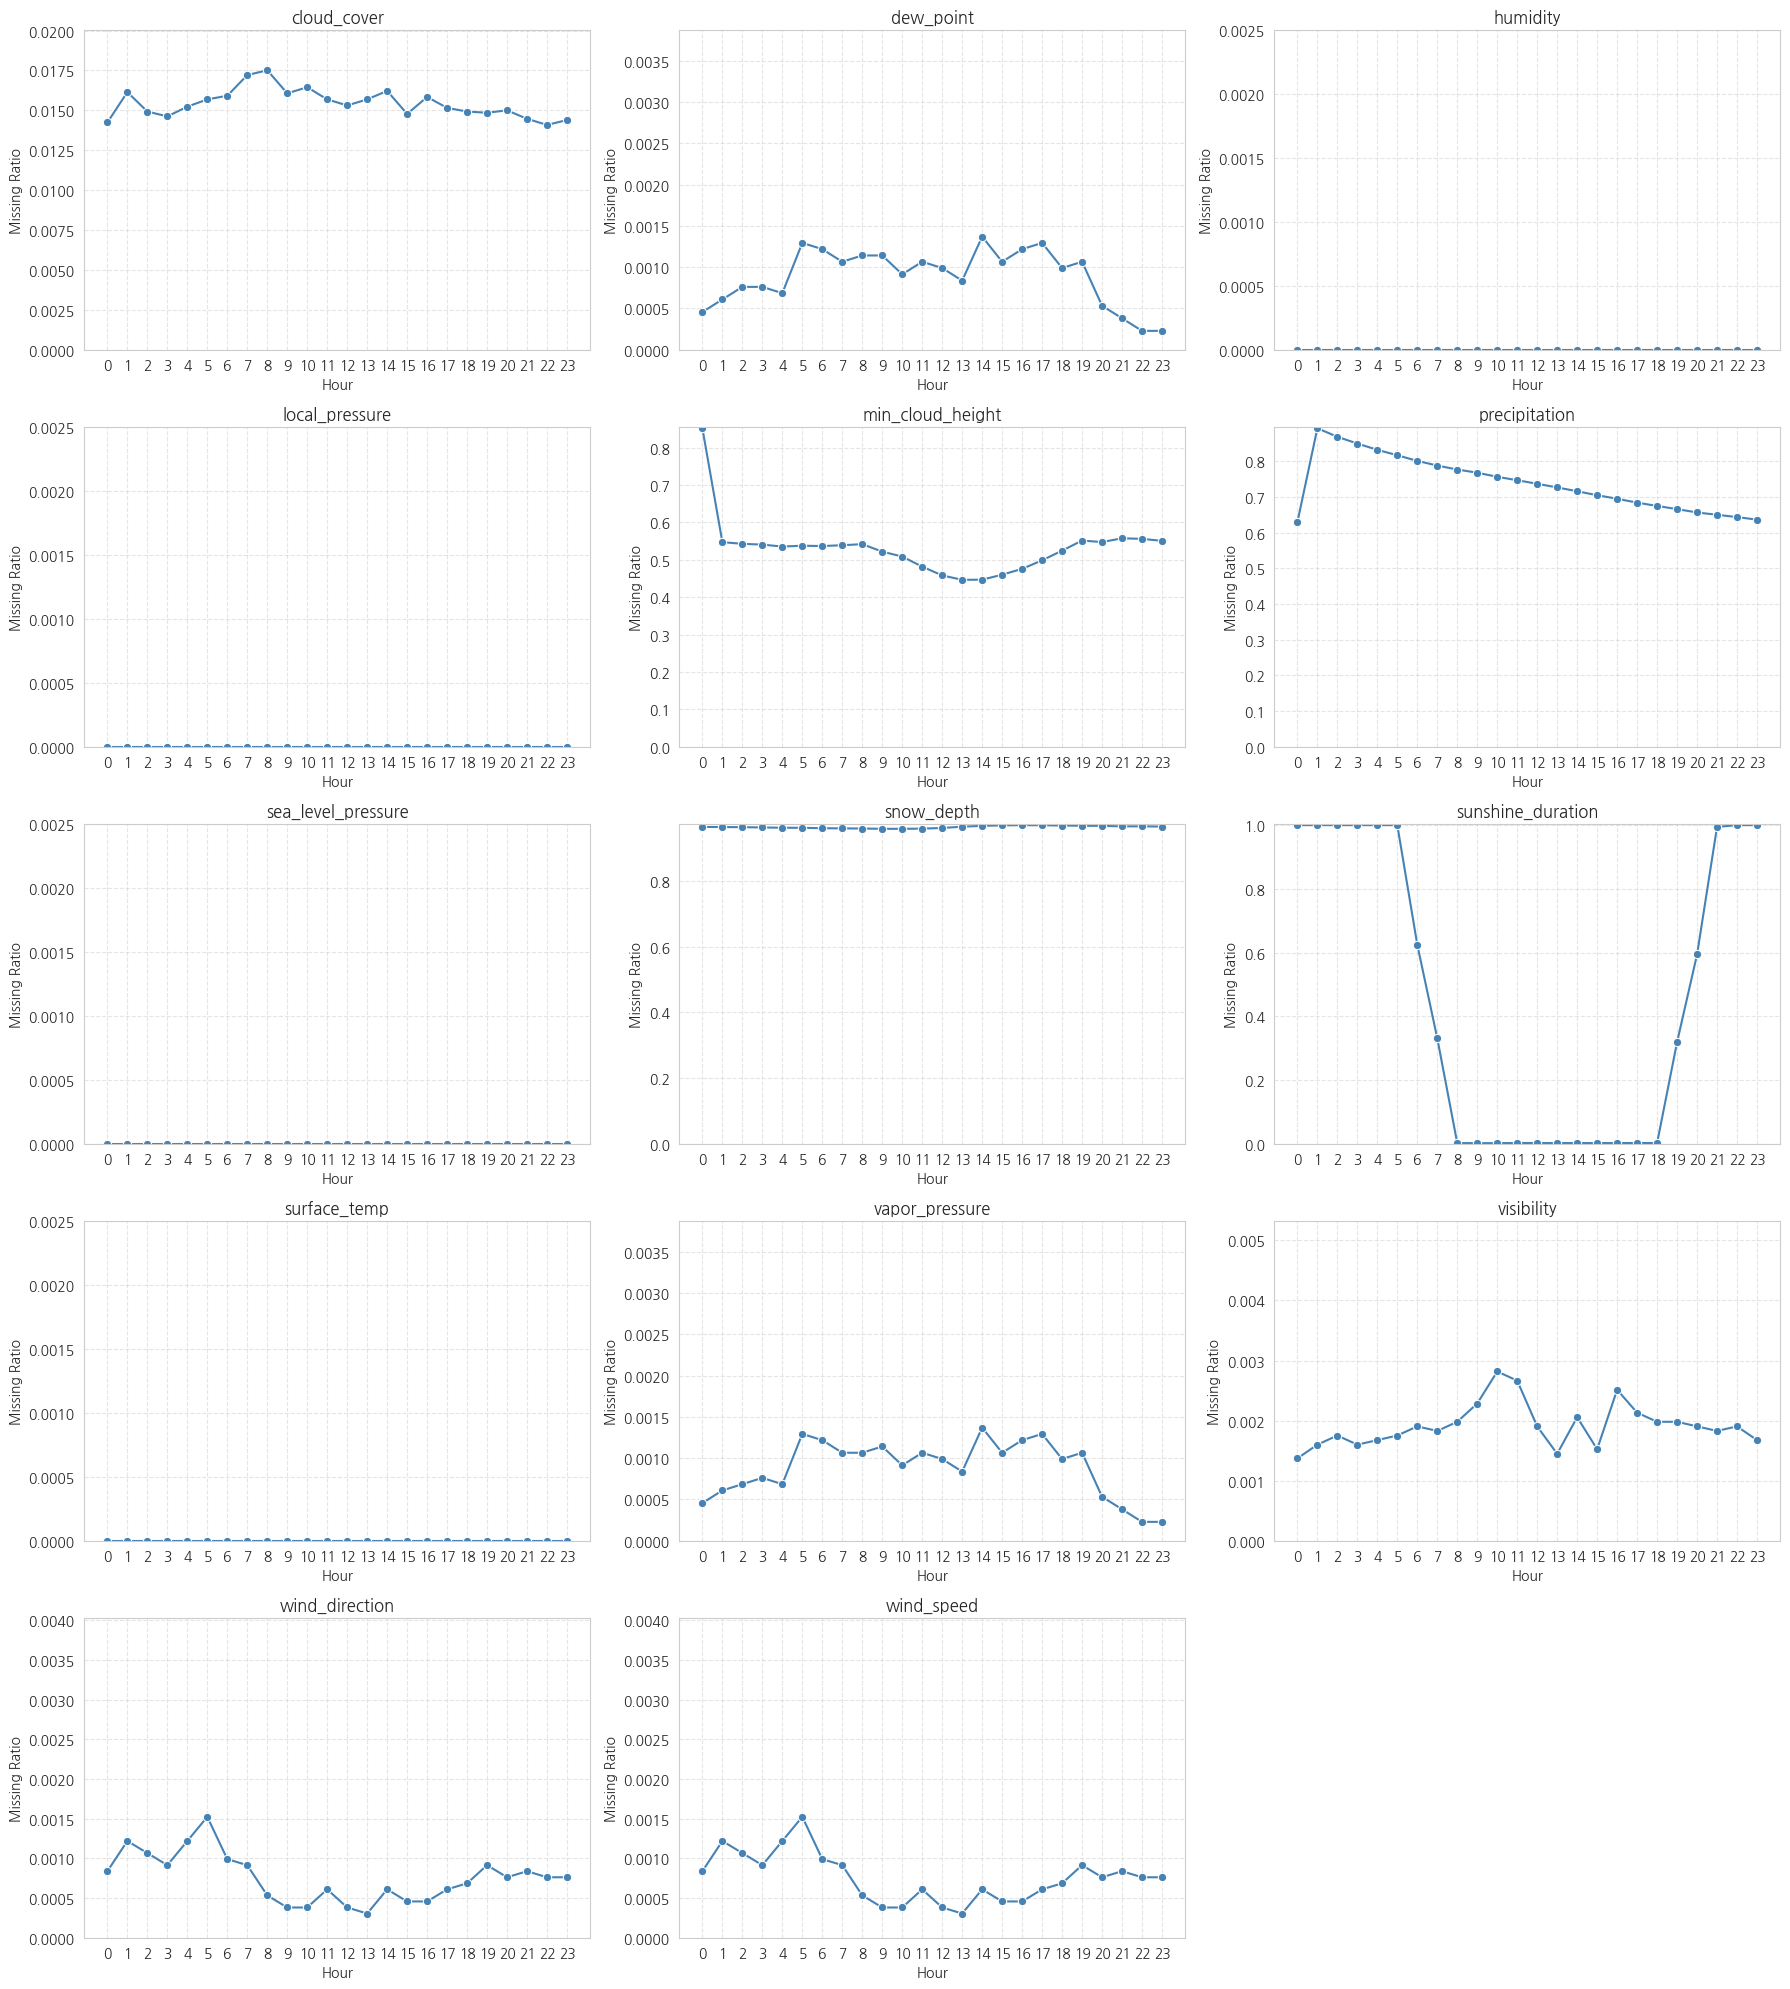

In [11]:
num_features = len(time_based_feature_names)
n_cols = 3
n_rows = math.ceil(num_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(sorted(time_based_feature_names)):
    analyze_time_based_features_missing_by_hour(axes[i], train_df, feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Time-based feature 종류별 평균 결측치 비율**

In [12]:
def analyze_missing_values_by_time_groups(df, time_based_feature_names):
    group_missing_summary = []

    for base_name in time_based_feature_names:
        cols = [col for col in df.columns if col.startswith(base_name + "_")]
        if not cols:
            continue
        missing_ratio = df[cols].isnull().mean().mean()  # 각 시간대의 평균 결측률
        group_missing_summary.append((base_name, missing_ratio))

    summary_df = pd.DataFrame(group_missing_summary, columns=["feature_group", "mean_missing_ratio"])
    summary_df = summary_df.sort_values(by="mean_missing_ratio", ascending=False).reset_index(drop=True)
    return summary_df

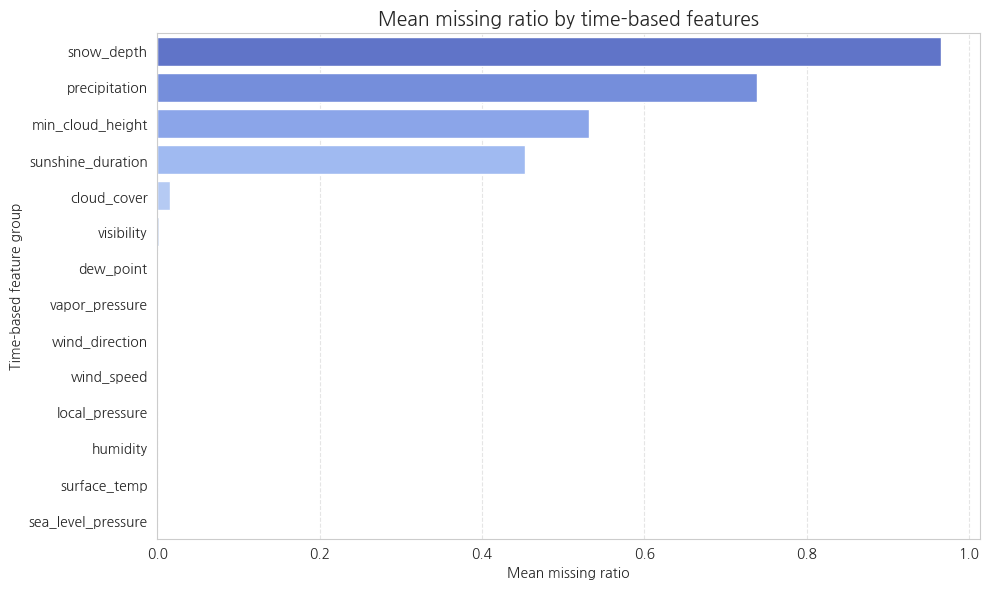

In [13]:
group_missing_ratio = analyze_missing_values_by_time_groups(train_df, time_based_feature_names)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=group_missing_ratio,
    x="mean_missing_ratio",
    y="feature_group",
    hue="feature_group",
    palette="coolwarm",
)
plt.title("Mean missing ratio by time-based features", fontsize=14)
plt.xlabel("Mean missing ratio")
plt.ylabel("Time-based feature group")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## EDA & Feature Engineering

### 결측치 처리

**결측치 처리 방법**

1. -9999는 NaN으로 처리
2. `snow_depth`, `precipitation`, `min_cloud_height`, `sunshine_duration`과 같이 결측치 비율이 높은 feature 처리 논의...
3. `sunshine_duration`이 야간에 결측치 -> 0으로 처리

In [14]:
def handle_missing_values(df):
    # 1. -9999를 NaN으로 변환
    df = df.replace(-9999, np.nan)

    # 2. 시간대별 특징에 맞게 처리
    night_hours = [0, 1, 2, 3, 4, 5, 22, 23]
    day_hours = [h for h in range(6, 22) if h not in night_hours]

    # 2.1. sunshine_duration
    # 2.1.1. 밤 시간대
    for hour in night_hours:
        col = f'sunshine_duration_{hour}'
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # 2.1.2. 낮 시간대
    for hour in day_hours:
        col = f'sunshine_duration_{hour}'
        if col in df.columns:
            df[col] = df.groupby('station')[col].transform(lambda x: x.fillna(x.mean()))
            # 낮시간대에 측정소 문제로 NaN이 있을 경우, global mean으로 대체함
            df[col] = df[col].fillna(df[col].mean())

    # 2.2. snow_depth
    # 눈이 오지 않는 계절에는 0으로 대체하고, 눈이 오는 계절에는 그룹별 평균으로 대체
    month_series = df['date'].str.split('-').str[0].astype(int)
    winter_mask = month_series.isin([12, 1, 2])

    for hour in range(24):
        col = f'snow_depth_{hour}'
        if col in df.columns:
            # 겨울철
            df.loc[winter_mask, col] = df.loc[winter_mask].groupby('station')[col].transform(
                lambda x: x.fillna(x.mean()))

            # 겨울 X -> 0으로 대체
            df.loc[~winter_mask, col] = df.loc[~winter_mask][col].fillna(0)

            # 겨울철에도 NaN이 남아있을 경우, global mean으로 대체
            df[col] = df[col].fillna(df[col].mean())


    # 2.3. percipitation
    # 지역별(측정소별) persistency가 존재할 것이므로, forward / back fill 사용(임시)
    for hour in range(24):
        col = f'precipitation_{hour}'
        if col in df.columns:
            df[col] = df.groupby('station')[col].transform(lambda x: x.ffill())
            df[col] = df.groupby('station')[col].transform(lambda x: x.bfill())
            df[col] = df[col].fillna(0) # 비 안오는 날은 0으로

    # 2.4. min_cloud_height
    # outlier 영향을 줄이기 위해 median 사용함
    for hour in range(24):
        col = f'min_cloud_height_{hour}'
        if col in df.columns:
            df[col] = df.groupby('station')[col].transform(lambda x: x.fillna(x.median()))
            df[col] = df[col].fillna(df[col].median())

    # 3. 나머지 feature 처리
    remaining_time_based_features = [
        'cloud_cover', 'dew_point', 'humidity', 'local_pressure',
        'sea_level_pressure', 'surface_temp', 'vapor_pressure',
        'visibility', 'wind_direction', 'wind_speed'
    ]

    for feature in remaining_time_based_features:
        for hour in range(24):
            col = f'{feature}_{hour}'
            if col in df.columns and df[col].isna().any():
                # station별 평균으로 대체
                df[col] = df.groupby('station')[col].transform(lambda x: x.fillna(x.mean()))
                # 남은 결측치는 global mean으로
                df[col] = df[col].fillna(df[col].mean())

    return df


In [15]:
print("결측치 처리 전 train_df 결측치 개수")
print(train_df.isnull().sum().sum())

train_df = handle_missing_values(train_df)

print("결측치 처리 후 train_df 결측치 개수")
print(train_df.isnull().sum().sum())

결측치 처리 전 train_df 결측치 개수
853979
결측치 처리 후 train_df 결측치 개수
0


### Time-based features 합치기

In [16]:
avg_columns = {}

for feature in time_based_feature_names:
    hourly_columns = [f'{feature}_{i}' for i in range(24) if f'{feature}_{i}' in train_df.columns]

    if hourly_columns:
        avg_columns[feature] = train_df[hourly_columns].mean(axis=1).values

keep = ['id', 'station', 'station_name', 'date', 'climatology_temp', 'target']
meta_df = train_df[keep].copy()

features_df = pd.DataFrame(avg_columns, index=train_df.index)
final_df = pd.concat([meta_df, features_df], axis=1)

final_df.head()

,id,station,station_name,date,climatology_temp,target,precipitation,sunshine_duration,cloud_cover,snow_depth,wind_direction,local_pressure,vapor_pressure,dew_point,humidity,surface_temp,visibility,sea_level_pressure,wind_speed,min_cloud_height
0,0,98,동두천,01-01,-2.707143,-3.992857,0.970833,0.325639,1.791667,2.594877,205.416667,1019.225000,1.666667,-16.808333,46.875000,-5.583333,1486.625000,1034.412500,1.704167,22.354167
1,1,98,동두천,01-02,-3.646429,-1.653571,0.970833,0.375639,0.000000,2.594877,145.833333,1019.962500,1.570833,-17.466667,45.500000,-5.762500,1419.750000,1035.141667,0.962500,11.562500
2,2,98,동두천,01-03,-2.694643,-0.005357,0.970833,0.375639,0.000000,2.594877,142.083333,1020.916667,1.554167,-17.645833,43.583333,-5.320833,1105.041667,1036.045833,0.841667,11.562500
3,3,98,동두천,01-04,-2.501786,-0.898214,0.970833,0.275639,1.208333,2.594877,160.416667,1016.854167,2.591667,-11.966667,53.166667,-3.920833,774.083333,1031.783333,1.025000,19.145833
4,4,98,동두천,01-05,-2.625000,-1.775000,0.970833,0.371473,0.250000,2.594877,217.083333,1013.066667,1.958333,-15.729167,40.583333,-3.391667,1274.000000,1027.925000,1.429167,13.229167


#### Correlation에 따라 feature 수 줄이기

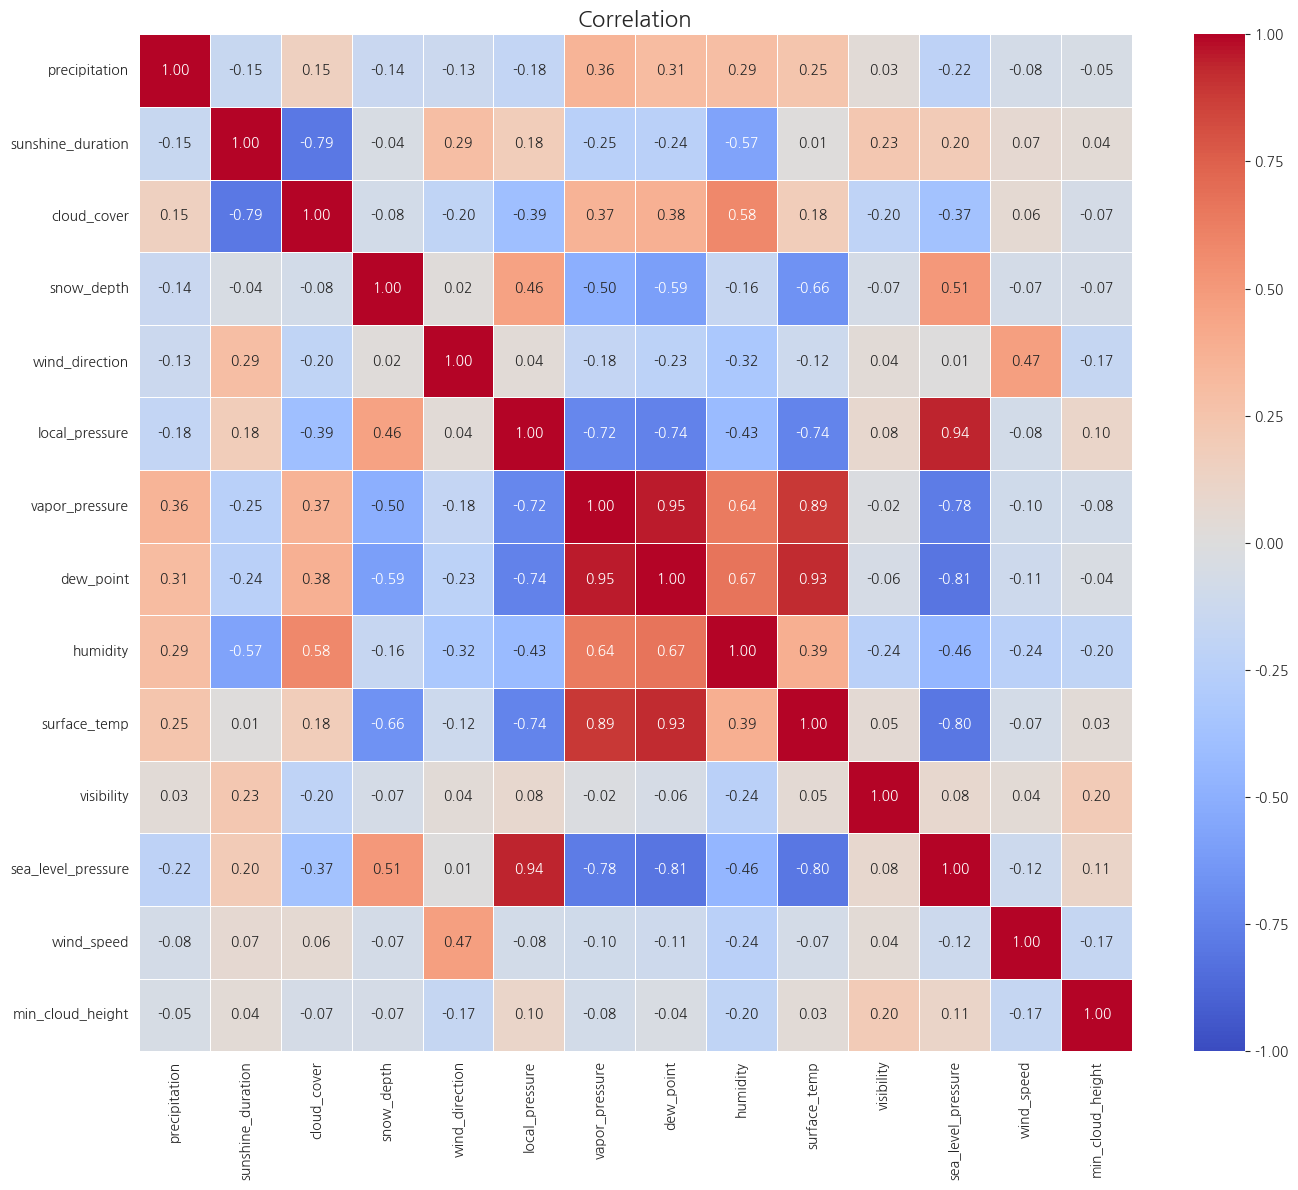

In [17]:
corr_matrix = final_df[list(time_based_feature_names)].copy().corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5)
plt.title('Correlation', fontsize=16)
plt.tight_layout()
plt.show()


#### 불필요한 feature를 제거하고, 측정소 정보 및 derived feature 추가

In [32]:
final_features = [
    'surface_temp', 'humidity', 'sea_level_pressure', 'cloud_cover', 'wind_speed', 'precipitation', 'snow_depth',
    'id', 'station', 'station_name', 'date', 'target', 'climatology_temp'
]

model_ready_df = final_df[final_features].copy()

model_ready_df['month'] = model_ready_df['date'].str.split('-').str[0].astype(int)
model_ready_df['day'] = model_ready_df['date'].str.split('-').str[1].astype(int)

model_ready_df['month_sin'] = np.sin(2 * np.pi * model_ready_df['month'] / 12)
model_ready_df['month_cos'] = np.cos(2 * np.pi * model_ready_df['month'] / 12)

station_dict = station_info_df.set_index('지점')

model_ready_df['latitude'] = model_ready_df['station'].map(station_dict['위도'].to_dict())
model_ready_df['longitude'] = model_ready_df['station'].map(station_dict['경도'].to_dict())
model_ready_df['elevation'] = model_ready_df['station'].map(station_dict['노장해발고도(m)'].to_dict())

model_ready_df.head()

,surface_temp,humidity,sea_level_pressure,cloud_cover,wind_speed,precipitation,snow_depth,id,station,station_name,date,target,climatology_temp,month,day,month_sin,month_cos,latitude,longitude,elevation
0,-5.583333,46.875000,1034.412500,1.791667,1.704167,0.970833,2.594877,0,98,동두천,01-01,-3.992857,-2.707143,1,1,0.5,0.866025,37.9019,127.0607,115.62
1,-5.762500,45.500000,1035.141667,0.000000,0.962500,0.970833,2.594877,1,98,동두천,01-02,-1.653571,-3.646429,1,2,0.5,0.866025,37.9019,127.0607,115.62
2,-5.320833,43.583333,1036.045833,0.000000,0.841667,0.970833,2.594877,2,98,동두천,01-03,-0.005357,-2.694643,1,3,0.5,0.866025,37.9019,127.0607,115.62
3,-3.920833,53.166667,1031.783333,1.208333,1.025000,0.970833,2.594877,3,98,동두천,01-04,-0.898214,-2.501786,1,4,0.5,0.866025,37.9019,127.0607,115.62
4,-3.391667,40.583333,1027.925000,0.250000,1.429167,0.970833,2.594877,4,98,동두천,01-05,-1.775000,-2.625000,1,5,0.5,0.866025,37.9019,127.0607,115.62


## Train

훈련 데이터 크기: (11158, 15)
검증 데이터 크기: (1974, 15)
사용 특성: ['surface_temp', 'humidity', 'sea_level_pressure', 'cloud_cover', 'wind_speed', 'precipitation', 'snow_depth', 'climatology_temp', 'month', 'day', 'month_sin', 'month_cos', 'latitude', 'longitude', 'elevation']

RandomForest 모델 학습 중...
RandomForest 결과:
  훈련 MAE: 0.5065
  검증 MAE: 2.6214
  훈련 RMSE: 0.6773
  검증 RMSE: 3.3601
  훈련 R²: 0.9388
  검증 R²: 0.2918

XGBoost 모델 학습 중...
XGBoost 결과:
  훈련 MAE: 1.0730
  검증 MAE: 2.5585
  훈련 RMSE: 1.4021
  검증 RMSE: 3.2613
  훈련 R²: 0.7377
  검증 R²: 0.3329

LightGBM 모델 학습 중...
LightGBM 결과:
  훈련 MAE: 1.1457
  검증 MAE: 2.5039
  훈련 RMSE: 1.4914
  검증 RMSE: 3.1734
  훈련 R²: 0.7032
  검증 R²: 0.3683

최적 모델: LightGBM (검증 MAE: 2.5039)

특성 중요도 상위 5개:
              feature  importance
0        surface_temp         553
7    climatology_temp         536
2  sea_level_pressure         332
9                 day         291
4          wind_speed         238


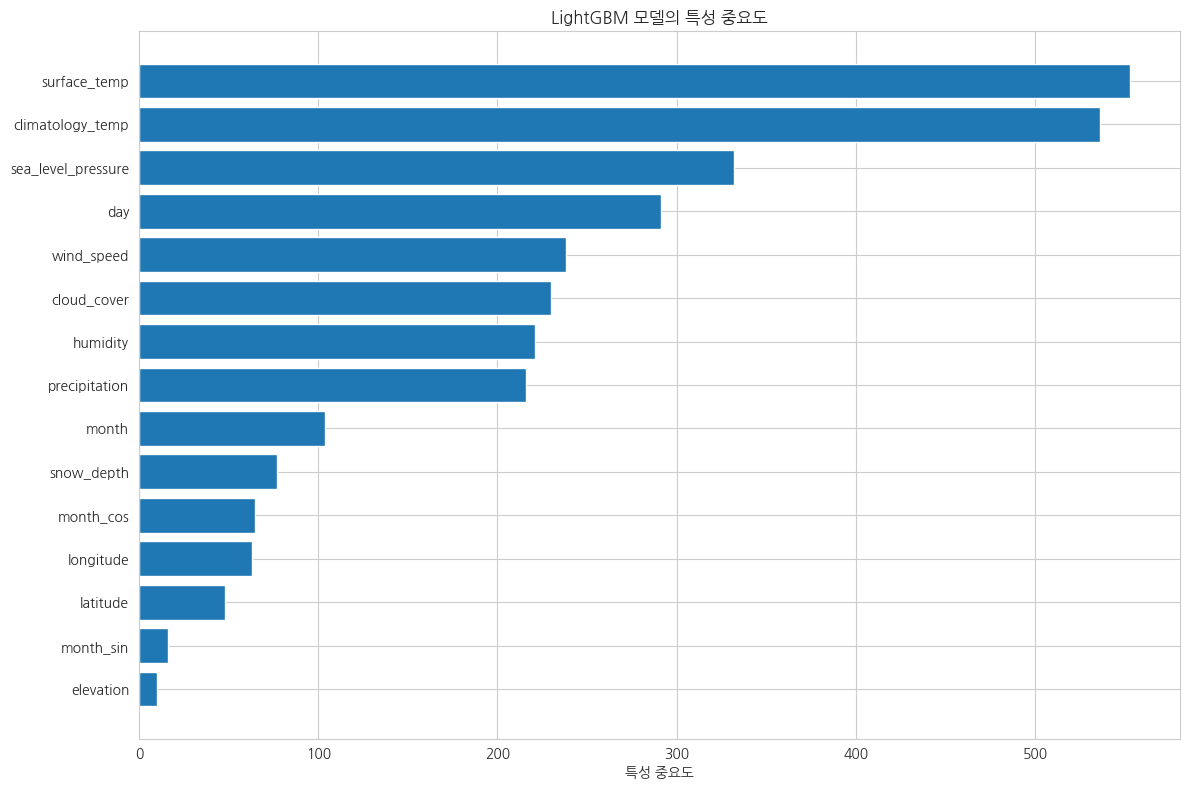

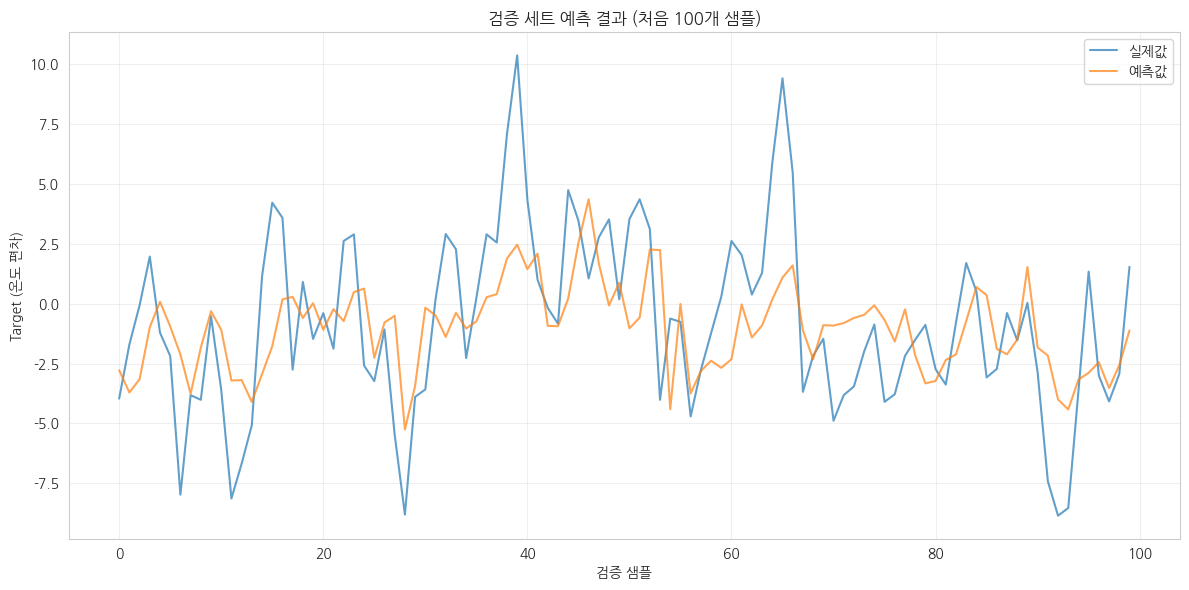


전체 데이터로 최종 모델 학습 중...
최종 LightGBM 모델 학습 완료!
모델 및 스케일러가 저장되었습니다.


In [33]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Apple Silicon 호환성을 위한 환경 설정
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# XGBoost와 LightGBM 임포트 (Apple Silicon 최적화)
try:
    import xgboost as xgb
    has_xgb = True
except ImportError:
    print("XGBoost를 사용할 수 없습니다. pip install xgboost 명령으로 설치하세요.")
    has_xgb = False

try:
    import lightgbm as lgb
    has_lgb = True
except ImportError:
    print("LightGBM을 사용할 수 없습니다. pip install lightgbm 명령으로 설치하세요.")
    has_lgb = False

# 1. 데이터 준비 - model_ready_df 사용

# 2. 훈련/검증 세트 분할
# 시간 순서 고려한 분할 (최근 15%를 검증 세트로)
unique_dates = sorted(model_ready_df['date'].unique())
train_dates = unique_dates[:int(len(unique_dates) * 0.85)]
val_dates = unique_dates[int(len(unique_dates) * 0.85):]

train_set = model_ready_df[model_ready_df['date'].isin(train_dates)]
val_set = model_ready_df[model_ready_df['date'].isin(val_dates)]

# 3. 특성과 타겟 분리
# 제외할 컬럼 (메타데이터)
exclude_cols = ['id', 'station', 'station_name', 'date', 'target', 'season']
feature_cols = [col for col in model_ready_df.columns if col not in exclude_cols]

X_train = train_set[feature_cols]
y_train = train_set['target']
X_val = val_set[feature_cols]
y_val = val_set['target']

print(f"훈련 데이터 크기: {X_train.shape}")
print(f"검증 데이터 크기: {X_val.shape}")
print(f"사용 특성: {feature_cols}")

# 4. 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 5. 모델 초기화 및 학습 (Apple Silicon 최적화)
models = {}

# 5.1 RandomForest
models['RandomForest'] = {
    'model': RandomForestRegressor(
        n_estimators=100,
        n_jobs=4,  # 코어 수 제한
        random_state=42
    )
}

# 5.2 XGBoost (있는 경우)
if has_xgb:
    models['XGBoost'] = {
        'model': xgb.XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            tree_method='hist',  # Apple Silicon 최적화
            n_jobs=4,  # 코어 수 제한
            random_state=42
        )
    }

# 5.3 LightGBM (있는 경우)
if has_lgb:
    models['LightGBM'] = {
        'model': lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            n_jobs=4,  # 코어 수 제한
            verbose=-1,  # 불필요한 출력 제거
            random_state=42
        )
    }

# 6. 모델 학습 및 평가
results = {}

for name, model_info in models.items():
    print(f"\n{name} 모델 학습 중...")
    model = model_info['model']
    model.fit(X_train_scaled, y_train)

    # 예측
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)

    # 성능 평가
    results[name] = {
        'train_mae': mean_absolute_error(y_train, train_pred),
        'val_mae': mean_absolute_error(y_val, val_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'val_rmse': np.sqrt(mean_squared_error(y_val, val_pred)),
        'train_r2': r2_score(y_train, train_pred),
        'val_r2': r2_score(y_val, val_pred)
    }

    # 모델 저장
    models[name]['predictions'] = {
        'train': train_pred,
        'val': val_pred
    }

    # 결과 출력
    print(f"{name} 결과:")
    print(f"  훈련 MAE: {results[name]['train_mae']:.4f}")
    print(f"  검증 MAE: {results[name]['val_mae']:.4f}")
    print(f"  훈련 RMSE: {results[name]['train_rmse']:.4f}")
    print(f"  검증 RMSE: {results[name]['val_rmse']:.4f}")
    print(f"  훈련 R²: {results[name]['train_r2']:.4f}")
    print(f"  검증 R²: {results[name]['val_r2']:.4f}")

# 7. 최적 모델 선택
best_model_name = min(results, key=lambda k: results[k]['val_mae'])
best_model = models[best_model_name]['model']
best_val_mae = results[best_model_name]['val_mae']

print(f"\n최적 모델: {best_model_name} (검증 MAE: {best_val_mae:.4f})")

# 8. 특성 중요도 분석
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    sorted_idx = np.argsort(best_model.feature_importances_)
    plt.barh(np.array(feature_cols)[sorted_idx], best_model.feature_importances_[sorted_idx])
    plt.xlabel('특성 중요도')
    plt.title(f'{best_model_name} 모델의 특성 중요도')
    plt.tight_layout()

    # 상위 5개 특성 출력
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\n특성 중요도 상위 5개:")
    print(importance_df.head(5))

# 9. 예측값 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_val.values[:100], label='실제값', alpha=0.7)
plt.plot(models[best_model_name]['predictions']['val'][:100], label='예측값', alpha=0.7)
plt.xlabel('검증 샘플')
plt.ylabel('Target (온도 편차)')
plt.title('검증 세트 예측 결과 (처음 100개 샘플)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 10. 전체 데이터로 최종 모델 훈련
print("\n전체 데이터로 최종 모델 학습 중...")
X_all = model_ready_df[feature_cols]
y_all = model_ready_df['target']
X_all_scaled = scaler.fit_transform(X_all)

# 최종 모델 학습
final_model = best_model.__class__(**best_model.get_params())
final_model.fit(X_all_scaled, y_all)

print(f"최종 {best_model_name} 모델 학습 완료!")

# 11. 모델 및 스케일러 저장
import joblib

# 최종 모델 및 스케일러 저장
joblib.dump(final_model, 'weather_prediction_model.joblib')
joblib.dump(scaler, 'weather_prediction_scaler.joblib')

print("모델 및 스케일러가 저장되었습니다.")

In [34]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Apple Silicon 호환성을 위한 환경 설정
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

print("LightGBM 모델 전체 데이터로 재학습 시작...")

# 1. 특성과 타겟 준비
exclude_cols = ['id', 'station', 'station_name', 'date', 'target']
feature_cols = [col for col in model_ready_df.columns if col not in exclude_cols]

X_all = model_ready_df[feature_cols]
y_all = model_ready_df['target']

print(f"전체 학습 데이터 크기: {X_all.shape}")
print(f"사용 특성: {feature_cols}")

# 2. 특성 스케일링
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# 3. LightGBM 모델 초기화 (Apple Silicon 최적화)
final_model = lgb.LGBMRegressor(
    n_estimators=200,          # 더 많은 트리로 성능 향상
    learning_rate=0.05,        # 과적합 줄이기 위해 낮춤
    num_leaves=31,             # 기본값
    min_child_samples=20,      # 과적합 방지
    subsample=0.8,             # 무작위성 추가
    colsample_bytree=0.8,      # 특성 샘플링
    n_jobs=4,                  # Apple Silicon 최적화
    verbose=-1,                # 불필요한 출력 제거
    random_state=42
)

# 4. 모델 학습
print(f"전체 데이터({len(X_all)} 샘플)로 LightGBM 모델 학습 중...")
final_model.fit(X_all_scaled, y_all)
print("학습 완료!")

# 5. 특성 중요도 확인
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n특성 중요도 상위 5개:")
print(importance_df.head(5))

# 6. 모델 및 스케일러 저장
model_file = 'weather_prediction_lightgbm.joblib'
scaler_file = 'weather_prediction_scaler.joblib'

joblib.dump(final_model, model_file)
joblib.dump(scaler, scaler_file)

print(f"\n모델이 '{model_file}'에 저장되었습니다.")
print(f"스케일러가 '{scaler_file}'에 저장되었습니다.")

# 7. 파주, 수원 예측 준비 완료 메시지
print("\n파주, 수원 데이터 예측 준비가 완료되었습니다.")
print("모델과 스케일러를 사용하여 새 위치의 데이터를 예측할 수 있습니다.")

# 8. 사용 예시 코드
print("\n새 위치 예측 사용 예시:")
print("""
# 예측 함수
def predict_for_new_location(new_data, scaler, model, climatology_temp):
    # 필요한 특성 확인
    required_features = [col for col in feature_cols if col not in ['latitude', 'longitude', 'elevation']]

    # 1. 위치 정보 추가
    if '파주' in new_data['station_name'].values[0]:
        new_data['latitude'] = 37.7599  # 파주 위도
        new_data['longitude'] = 126.7743  # 파주 경도
        new_data['elevation'] = 29.0  # 파주 고도
    elif '수원' in new_data['station_name'].values[0]:
        new_data['latitude'] = 37.2575  # 수원 위도
        new_data['longitude'] = 127.0209  # 수원 경도
        new_data['elevation'] = 34.0  # 수원 고도

    # 2. 특성 스케일링
    X_new = new_data[feature_cols]
    X_new_scaled = scaler.transform(X_new)

    # 3. 온도 편차 예측
    temp_anomaly = model.predict(X_new_scaled)

    # 4. 실제 온도 계산 (편차 + 기후학적 평균)
    actual_temp = temp_anomaly + climatology_temp

    return actual_temp
""")

LightGBM 모델 전체 데이터로 재학습 시작...
전체 학습 데이터 크기: (13132, 15)
사용 특성: ['surface_temp', 'humidity', 'sea_level_pressure', 'cloud_cover', 'wind_speed', 'precipitation', 'snow_depth', 'climatology_temp', 'month', 'day', 'month_sin', 'month_cos', 'latitude', 'longitude', 'elevation']
전체 데이터(13132 샘플)로 LightGBM 모델 학습 중...
학습 완료!

특성 중요도 상위 5개:
              feature  importance
0        surface_temp        1041
7    climatology_temp         991
2  sea_level_pressure         608
4          wind_speed         514
9                 day         503

모델이 'weather_prediction_lightgbm.joblib'에 저장되었습니다.
스케일러가 'weather_prediction_scaler.joblib'에 저장되었습니다.

파주, 수원 데이터 예측 준비가 완료되었습니다.
모델과 스케일러를 사용하여 새 위치의 데이터를 예측할 수 있습니다.

새 위치 예측 사용 예시:

# 예측 함수
def predict_for_new_location(new_data, scaler, model, climatology_temp):
    # 필요한 특성 확인
    required_features = [col for col in feature_cols if col not in ['latitude', 'longitude', 'elevation']]

    # 1. 위치 정보 추가
    if '파주' in new_data['station_name'].values[0]:
  

## Predict

In [36]:
import pandas as pd
import numpy as np
import joblib

# 1. 모델 및 스케일러 로드
model = joblib.load('weather_prediction_lightgbm.joblib')
scaler = joblib.load('weather_prediction_scaler.joblib')

# 2. 테스트 데이터 변환 함수
def prepare_test_data(test_df, station_info_df):
    """
    원본 형태(336개 컬럼)의 테스트 데이터를 모델 입력 형태로 변환
    """
    print("테스트 데이터 변환 중...")


    keep_features = [
        'surface_temp', 'humidity', 'sea_level_pressure',
        'cloud_cover', 'wind_speed', 'precipitation', 'snow_depth'
    ]

    # 2.2 메타데이터 컬럼
    id_cols = ['id', 'station', 'station_name', 'date']

    # 2.3 각 기상 변수별 24시간 데이터를 하나의 특성으로 압축
    test_ready_df = test_df[id_cols + ['climatology_temp']].copy()

    for feature in keep_features:
        # 해당 변수의 모든 시간대 컬럼 가져오기
        hourly_columns = [f'{feature}_{i}' for i in range(24) if f'{feature}_{i}' in test_df.columns]

        if hourly_columns:
            # 평균 계산하여 새 컬럼 생성
            test_ready_df[feature] = test_df[hourly_columns].mean(axis=1)

    # 2.4 날짜 정보 처리
    test_ready_df['month'] = test_ready_df['date'].str.split('-').str[0].astype(int)
    test_ready_df['day'] = test_ready_df['date'].str.split('-').str[1].astype(int)

    # 월을 사인/코사인으로 변환 (계절성 표현)
    test_ready_df['month_sin'] = np.sin(2 * np.pi * test_ready_df['month'] / 12)
    test_ready_df['month_cos'] = np.cos(2 * np.pi * test_ready_df['month'] / 12)

    # 2.5 위치 정보 추가
    location_map = station_info_df.set_index('지점')
    test_ready_df['latitude'] = test_ready_df['station'].map(location_map['위도'].to_dict())
    test_ready_df['longitude'] = test_ready_df['station'].map(location_map['경도'].to_dict())
    test_ready_df['elevation'] = test_ready_df['station'].map(location_map['노장해발고도(m)'].to_dict())

    print(f"테스트 데이터 변환 완료: {test_ready_df.shape}")
    return test_ready_df

# 3. 예측 수행 함수
def predict_temperature_anomaly(test_ready_df, model, scaler):
    """
    변환된 테스트 데이터로 온도 편차 예측
    """
    # 3.1 특성 컬럼 선택 (예측에 사용되는 컬럼만)
    # 중요: climatology_temp는 제외하지 않음!
    id_cols = ['id', 'station', 'station_name', 'date']
    feature_cols = [col for col in test_ready_df.columns if col not in id_cols]

    # 3.2 특성 데이터 준비
    X_test = test_ready_df[feature_cols]

    # 3.3 특성 스케일링
    X_test_scaled = scaler.transform(X_test)

    # 3.4 온도 편차 예측
    temp_anomaly = model.predict(X_test_scaled)

    # 3.5 결과 데이터프레임 생성
    results_df = test_ready_df[id_cols + ['climatology_temp']].copy()
    results_df['predicted_anomaly'] = temp_anomaly  # 예측된 온도 편차

    # 3.6 완성된 평균 온도 계산 (optional)
    results_df['predicted_avg_temp'] = results_df['predicted_anomaly'] + results_df['climatology_temp']

    return results_df

# 4. 전체 예측 파이프라인 실행 함수
def run_prediction_pipeline(test_file, station_info_file, model, scaler, output_file='predictions.csv'):
    """
    테스트 파일을 읽고, 변환하고, 예측하는 전체 파이프라인 실행
    """
    print(f"테스트 파일 '{test_file}' 로드 중...")
    test_df = pd.read_csv(test_file)

    print(f"측정소 정보 파일 '{station_info_file}' 로드 중...")
    station_info_df = pd.read_csv(station_info_file)

    # 파주, 수원 정보가 없는 경우 추가
    if not any(station_info_df['지점명'].str.contains('파주')):
        print("파주 측정소 정보 추가...")
        paju_info = {
            '지점': 99999,  # 임시 ID
            '지점명': '파주',
            '위도': 37.7599,
            '경도': 126.7743,
            '노장해발고도(m)': 29.0
        }
        station_info_df = pd.concat([station_info_df, pd.DataFrame([paju_info])], ignore_index=True)

    if not any(station_info_df['지점명'].str.contains('수원')):
        print("수원 측정소 정보 추가...")
        suwon_info = {
            '지점': 99998,  # 임시 ID
            '지점명': '수원',
            '위도': 37.2575,
            '경도': 127.0209,
            '노장해발고도(m)': 34.0
        }
        station_info_df = pd.concat([station_info_df, pd.DataFrame([suwon_info])], ignore_index=True)

    # 데이터 변환
    test_ready_df = prepare_test_data(test_df, station_info_df)

    # 온도 예측
    results_df = predict_temperature_anomaly(test_ready_df, model, scaler)

    # 예측 결과 저장
    results_df[['id', 'predicted_anomaly']].to_csv(output_file, index=False)
    print(f"예측 완료. 결과가 '{output_file}'에 저장되었습니다.")

    return results_df

# 사용 예시

# 모델과 스케일러 로드
model = joblib.load('weather_prediction_lightgbm.joblib')
scaler = joblib.load('weather_prediction_scaler.joblib')

# 예측 파이프라인 실행
results = run_prediction_pipeline(
    test_file='./input/test_dataset.csv',
    station_info_file='./input/station_info.csv',
    model=model,
    scaler=scaler,
    output_file='submission.csv'
)

# 예측 결과 확인
print(results.head())


테스트 파일 './input/test_dataset.csv' 로드 중...
측정소 정보 파일 './input/station_info.csv' 로드 중...
테스트 데이터 변환 중...
테스트 데이터 변환 완료: (4379, 19)
   surface_temp   humidity  sea_level_pressure  cloud_cover  wind_speed  \
0     -5.583333  46.875000         1034.412500     1.791667    1.704167   
1     -5.762500  45.500000         1035.141667     0.000000    0.962500   
2     -5.320833  43.583333         1036.045833     0.000000    0.841667   
3     -3.920833  53.166667         1031.783333     1.208333    1.025000   
4     -3.391667  40.583333         1027.925000     0.250000    1.429167   

   precipitation  snow_depth  id  station station_name   date    target  \
0       0.970833    2.594877   0       98          동두천  01-01 -3.992857   
1       0.970833    2.594877   1       98          동두천  01-02 -1.653571   
2       0.970833    2.594877   2       98          동두천  01-03 -0.005357   
3       0.970833    2.594877   3       98          동두천  01-04 -0.898214   
4       0.970833    2.594877   4       98    

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.
